In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from google.colab import drive
import pandas as pd

In [62]:
# 1. Konfigurasi Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
# 2. Membaca Dataset
file_path = '/content/drive/MyDrive/Data set Week 14/iris.data'  # Ganti dengan path file Anda
try:
    df = pd.read_csv(file_path, header=None)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Pastikan path file benar.")
    exit()


In [64]:
# Pisahkan fitur dan label
data = df.iloc[:, :-1].values.astype(float)  # Semua kolom kecuali yang terakhir
labels = df.iloc[:, -1].values

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
print("Data sample:")
print(data[:5])
print("Labels sample:")
print(labels[:5])


Data shape: (150, 4)
Labels shape: (150,)
Data sample:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
Labels sample:
['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa']


In [65]:
# Cetak Data
print("Dataframe head:")
print(df.head())

Dataframe head:
     0    1    2    3            4
0  5.1  3.5  1.4  0.2  Iris-setosa
1  4.9  3.0  1.4  0.2  Iris-setosa
2  4.7  3.2  1.3  0.2  Iris-setosa
3  4.6  3.1  1.5  0.2  Iris-setosa
4  5.0  3.6  1.4  0.2  Iris-setosa


In [66]:
# 3. Pra-pemrosesan Data
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Ubah data dan label menjadi tensor
features = torch.tensor(scaled_data, dtype=torch.float32)
targets = torch.tensor(encoded_labels, dtype=torch.long)

print("Scaled Features shape:", features.shape)
print("Encoded Labels shape:", targets.shape)

# Buat dataset custom
class SequenceDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Buat Dataset dan Dataloader
train_dataset = SequenceDataset(X_train, y_train)
test_dataset = SequenceDataset(X_test, y_test)

Scaled Features shape: torch.Size([150, 4])
Encoded Labels shape: torch.Size([150])


In [67]:
# 4. Definisi Model RNN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, pooling_type='max'):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.pooling_type = pooling_type
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x.shape: (batch_size, seq_len, input_size)
        # asumsi seq_len=1, karena data kita bukan sequential
        # Tambahkan dimensi urutan (sequence)
        x = x.unsqueeze(1)
        output, _ = self.rnn(x) # output shape: (batch_size, seq_len, hidden_size)

        if self.pooling_type == 'max':
            output, _ = torch.max(output, dim=1)  #output shape (batch_size, hidden_size)
        elif self.pooling_type == 'avg':
            output = torch.mean(output, dim=1) #output shape (batch_size, hidden_size)

        output = self.fc(output) #output shape (batch_size, num_classes)
        return output


# Inisialisasi Model, Loss function dan Optimizer
input_size = data.shape[1]
num_classes = len(np.unique(encoded_labels))

In [68]:
# 5. Konfigurasi Training Loop
def train_model(model, train_dataloader, test_dataloader, optimizer, criterion, epochs, early_stopper_patience, learning_rate_scheduler):
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for features, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Test Model
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for features, targets in test_dataloader:
                outputs = model(features)
                loss = criterion(outputs, targets)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_losses.append(avg_test_loss)


        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

        # Early Stopping
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopper_patience:
            print("Early stopping triggered")
            break

        # Learning Rate Scheduler
        learning_rate_scheduler.step()

    return train_losses, test_losses

In [69]:
# 6. Eksperimen dan Perbandingan
hidden_sizes = [32, 64, 128]
pooling_types = ['max', 'avg']
epochs_list = [5, 50, 100, 250, 350]
optimizers = ['SGD', 'RMSprop', 'Adam']
early_stopper_patience = 20
learning_rate_scheduler_step_size = 10 # step size untuk learning rate scheduler
learning_rate_scheduler_gamma = 0.1 # gamma untuk learning rate scheduler

train_batch_size = 16
test_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

criterion = nn.CrossEntropyLoss()
results = {}

for hidden_size in hidden_sizes:
    for pooling_type in pooling_types:
        for epochs in epochs_list:
            for optimizer_name in optimizers:
                print(f"Training with hidden size: {hidden_size}, pooling: {pooling_type}, epochs: {epochs}, optimizer: {optimizer_name}")

                model = RNNModel(input_size, hidden_size, num_classes, pooling_type)

                if optimizer_name == 'SGD':
                   optimizer = optim.SGD(model.parameters(), lr=0.01)
                elif optimizer_name == 'RMSprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=0.001)
                elif optimizer_name == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=0.001)

                learning_rate_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=learning_rate_scheduler_step_size, gamma=learning_rate_scheduler_gamma)

                train_losses, test_losses = train_model(model, train_dataloader, test_dataloader, optimizer, criterion, epochs, early_stopper_patience, learning_rate_scheduler)

                results[(hidden_size, pooling_type, epochs, optimizer_name)] = {
                    'train_losses': train_losses,
                    'test_losses': test_losses
                }

print("Finished training!")

Output streaming akan dipotong hingga 5000 baris terakhir.
Epoch 15/350, Train Loss: 0.8130, Test Loss: 0.7959
Epoch 16/350, Train Loss: 0.8102, Test Loss: 0.7932
Epoch 17/350, Train Loss: 0.8064, Test Loss: 0.7906
Epoch 18/350, Train Loss: 0.8137, Test Loss: 0.7881
Epoch 19/350, Train Loss: 0.8059, Test Loss: 0.7855
Epoch 20/350, Train Loss: 0.8102, Test Loss: 0.7830
Epoch 21/350, Train Loss: 0.8029, Test Loss: 0.7827
Epoch 22/350, Train Loss: 0.8042, Test Loss: 0.7825
Epoch 23/350, Train Loss: 0.8017, Test Loss: 0.7822
Epoch 24/350, Train Loss: 0.7956, Test Loss: 0.7820
Epoch 25/350, Train Loss: 0.8020, Test Loss: 0.7817
Epoch 26/350, Train Loss: 0.7933, Test Loss: 0.7814
Epoch 27/350, Train Loss: 0.7988, Test Loss: 0.7812
Epoch 28/350, Train Loss: 0.7992, Test Loss: 0.7809
Epoch 29/350, Train Loss: 0.7997, Test Loss: 0.7807
Epoch 30/350, Train Loss: 0.7937, Test Loss: 0.7804
Epoch 31/350, Train Loss: 0.8003, Test Loss: 0.7804
Epoch 32/350, Train Loss: 0.7982, Test Loss: 0.7804
Epoch

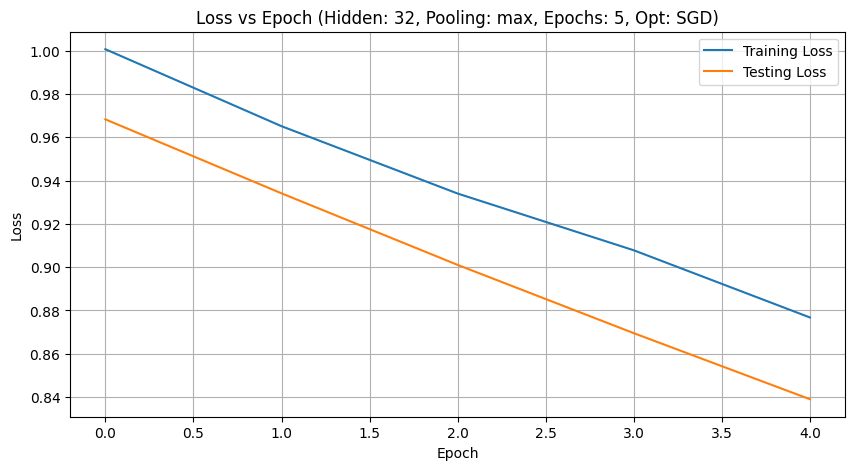

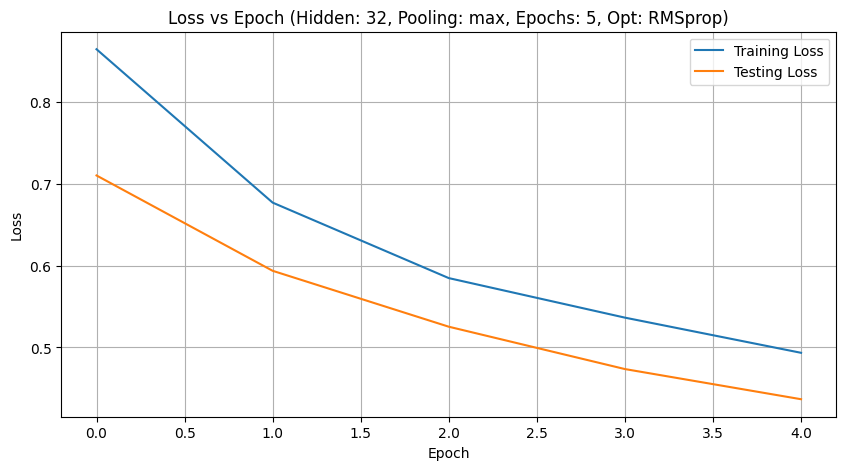

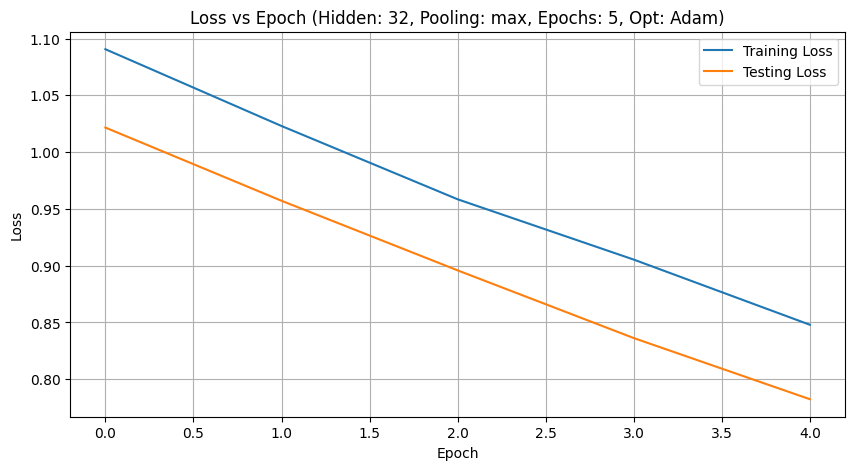

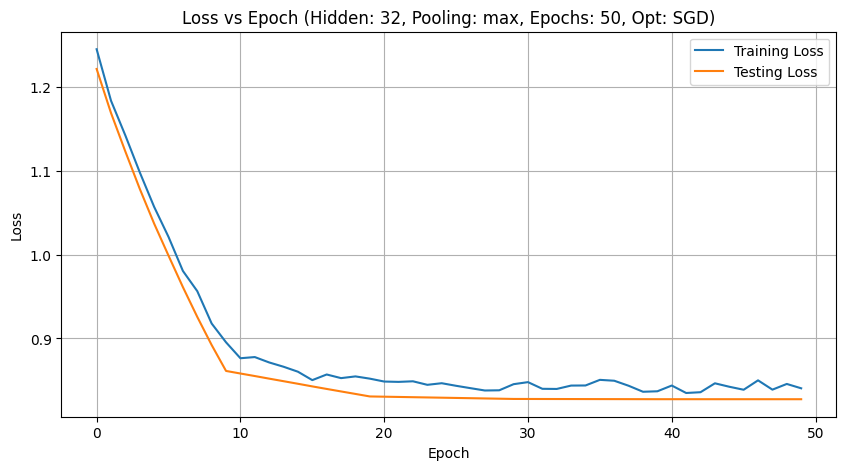

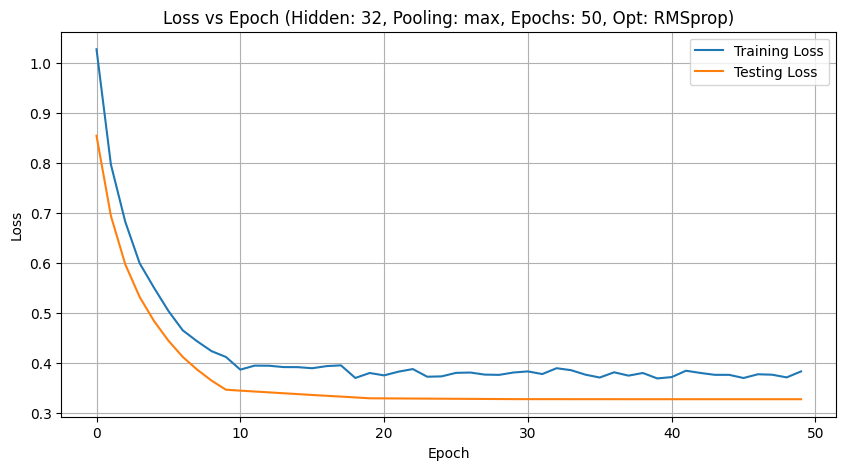

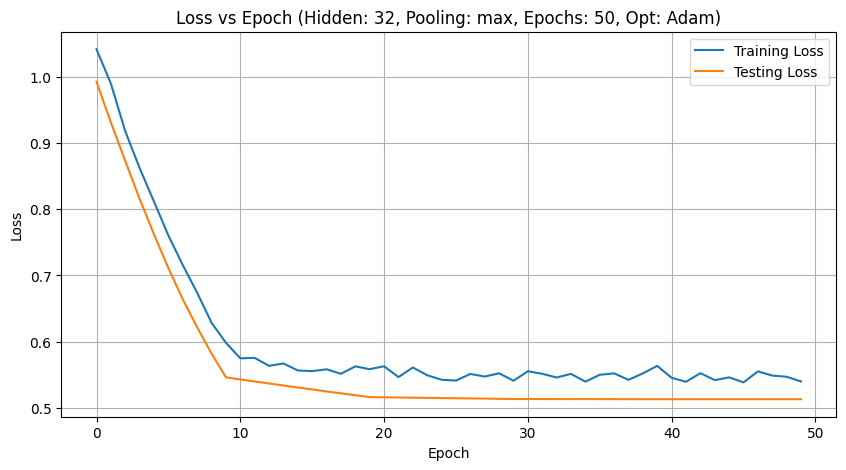

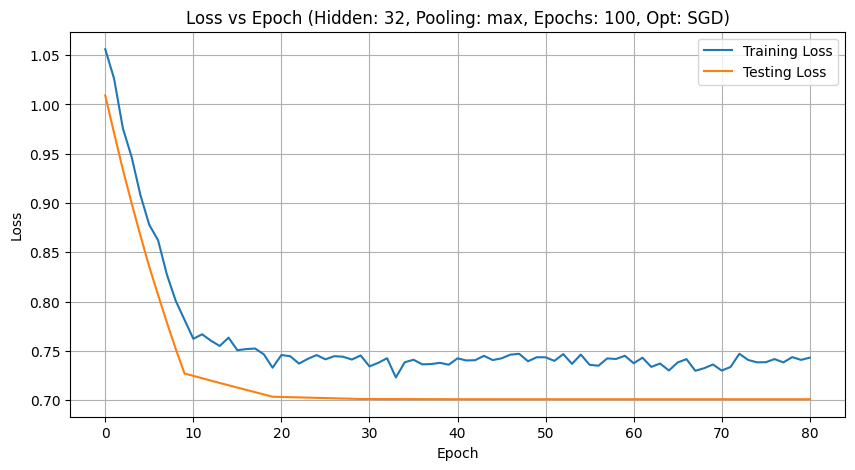

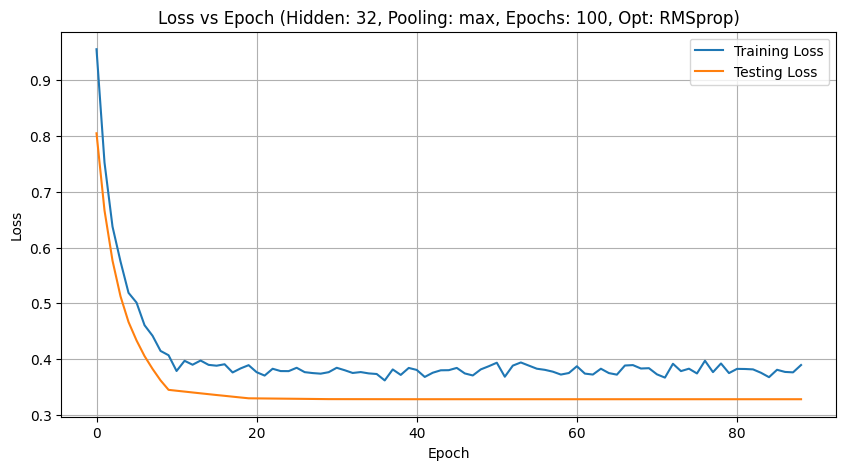

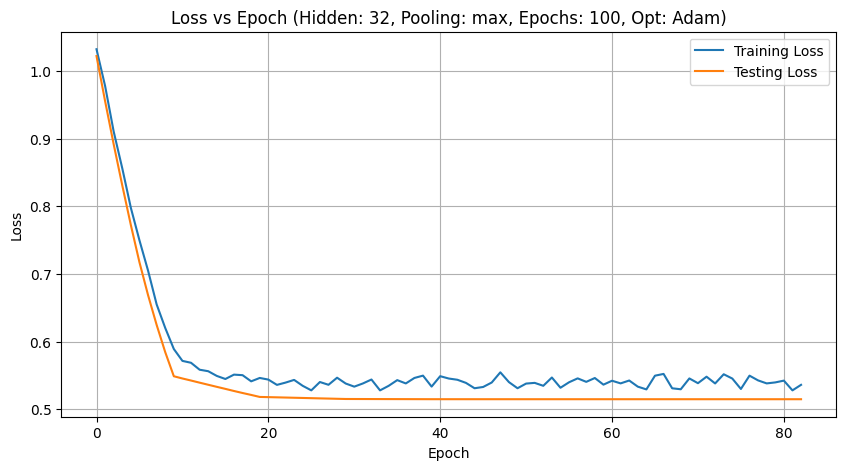

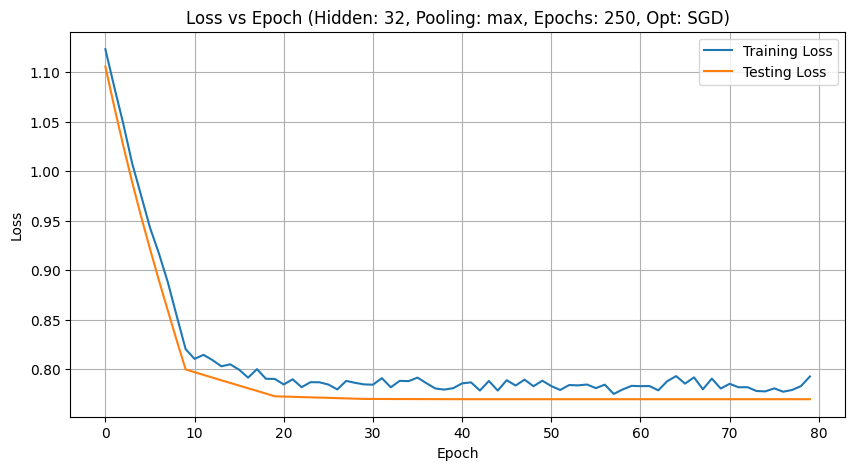

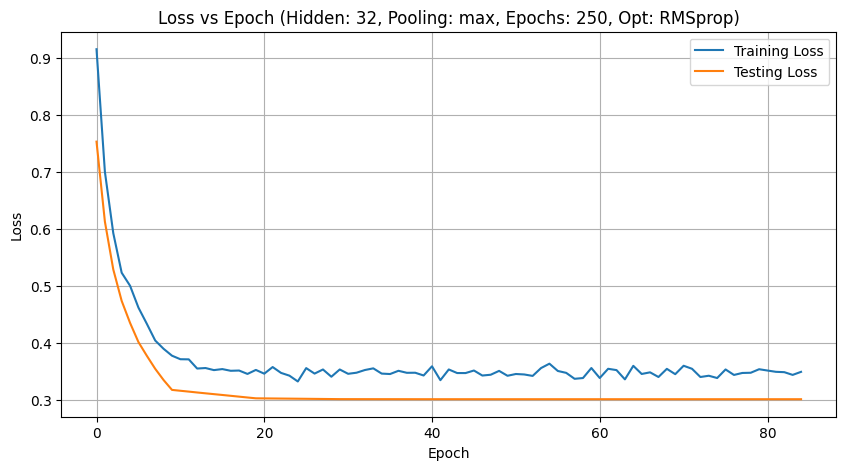

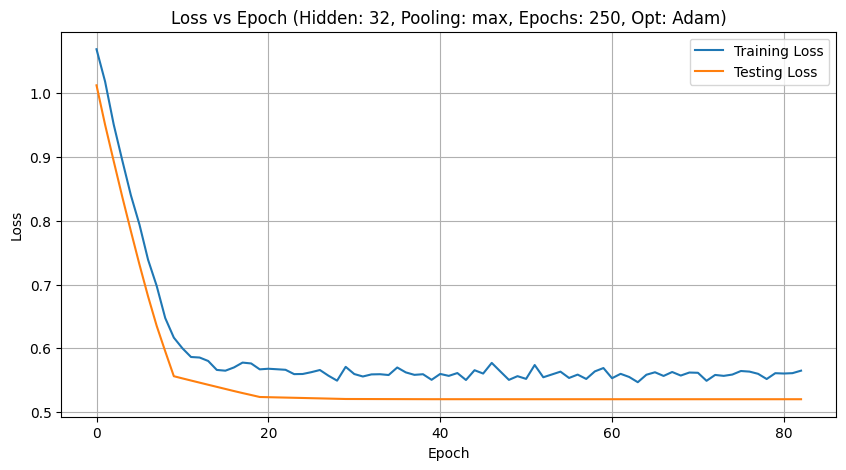

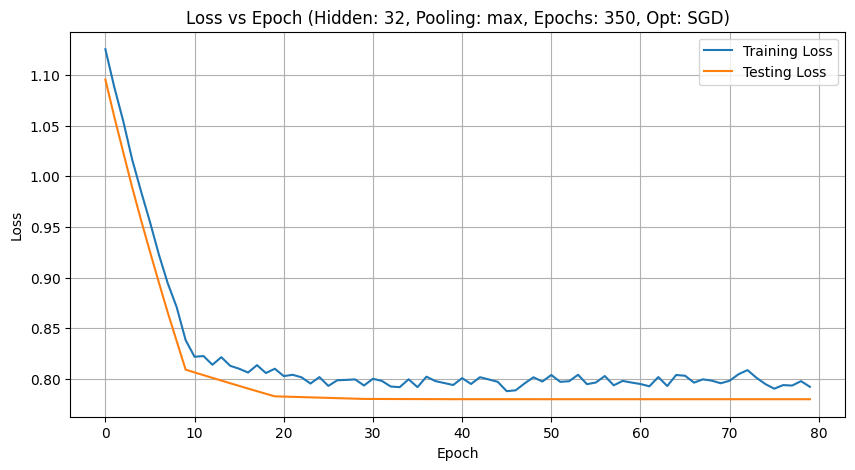

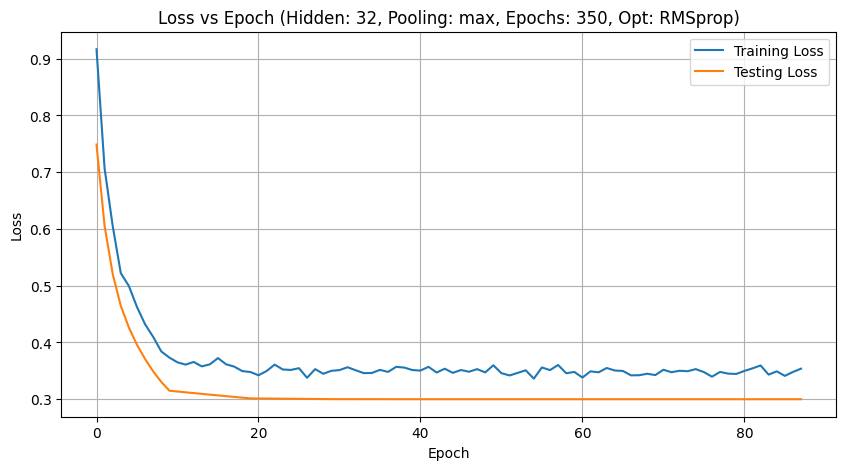

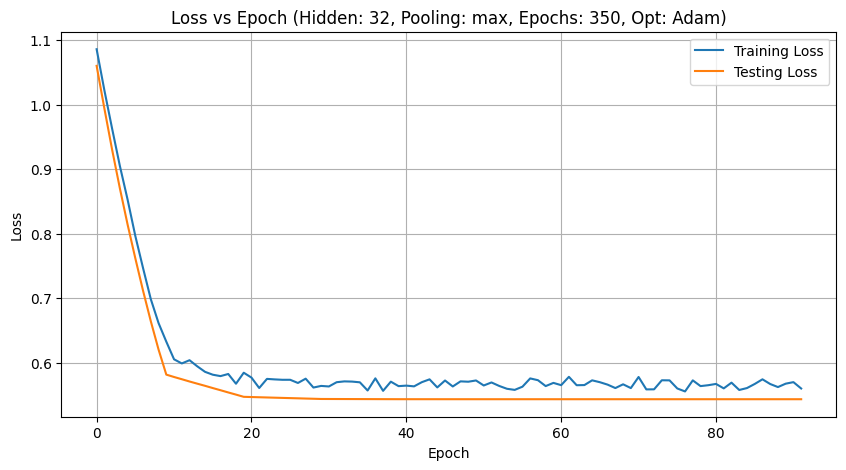

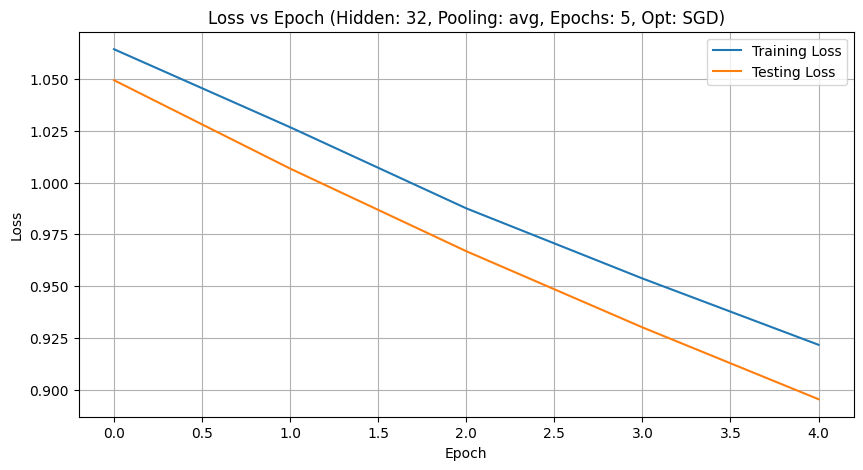

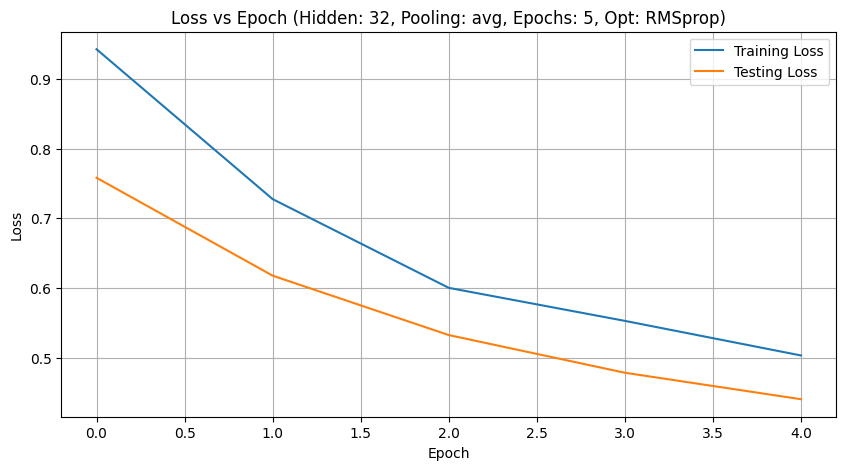

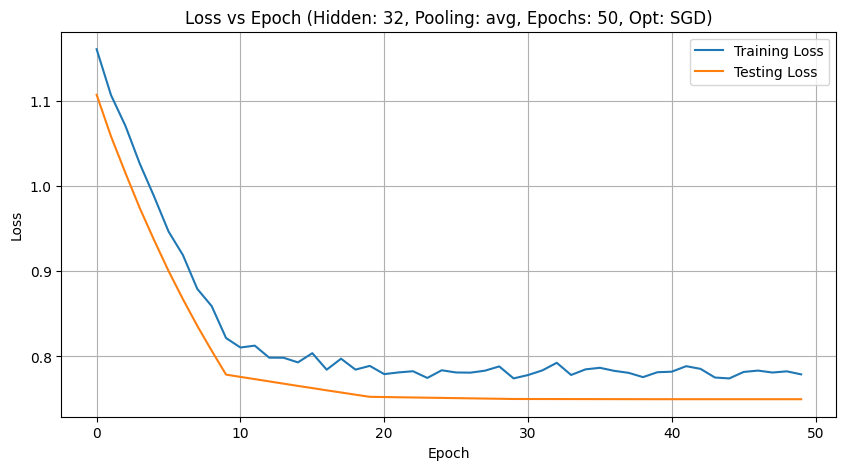

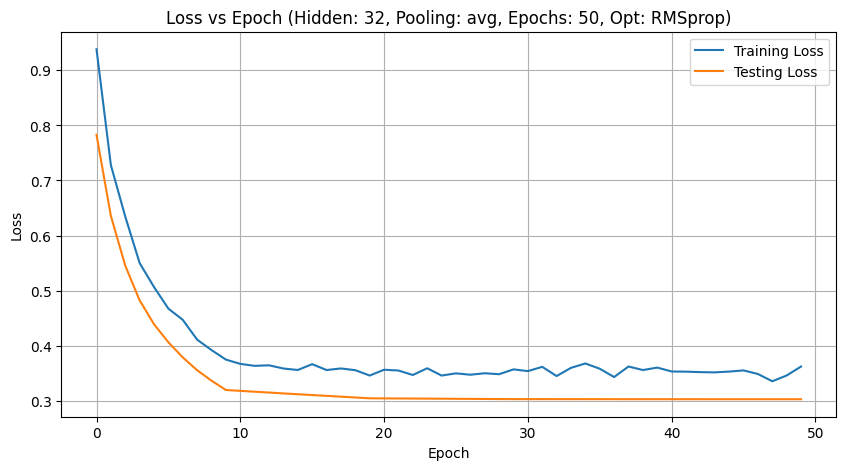

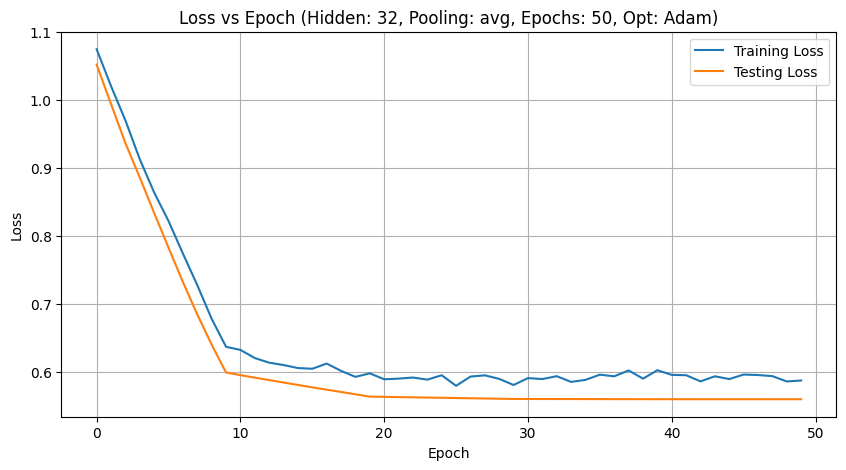

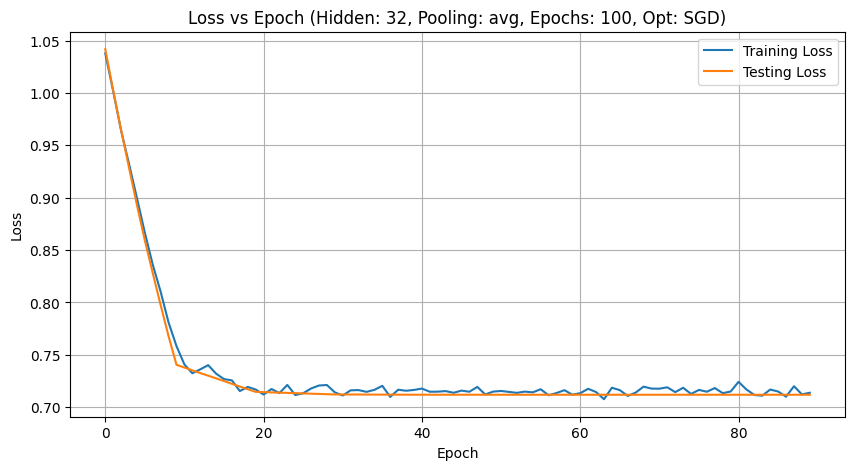

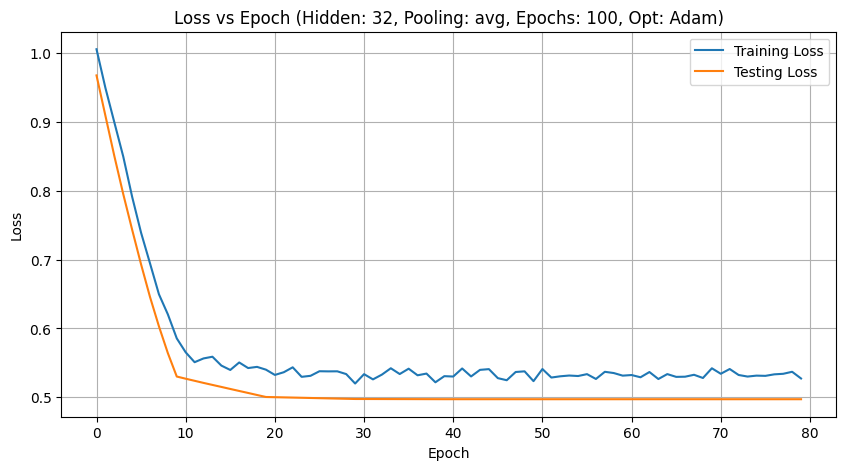

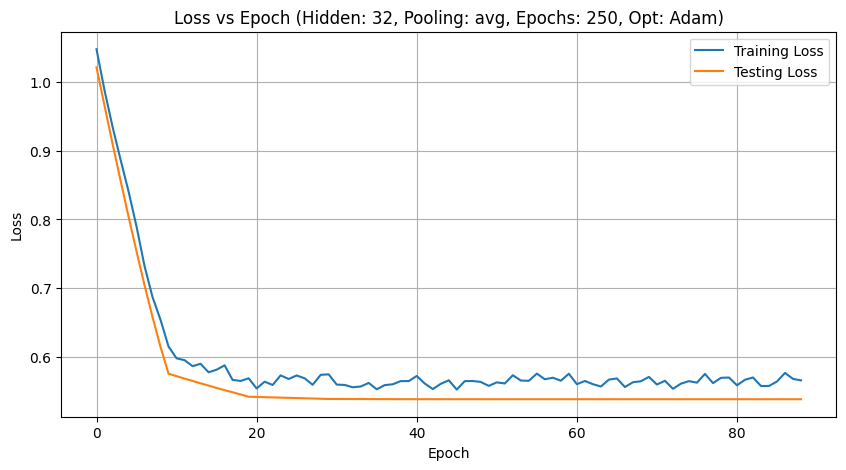

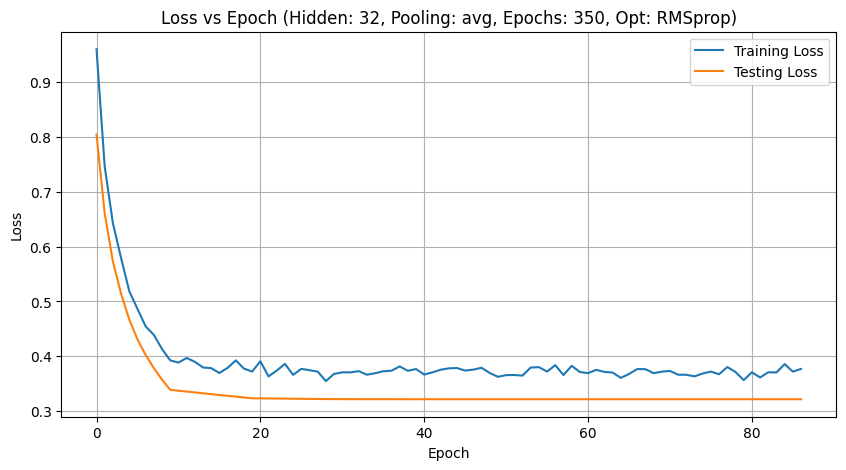

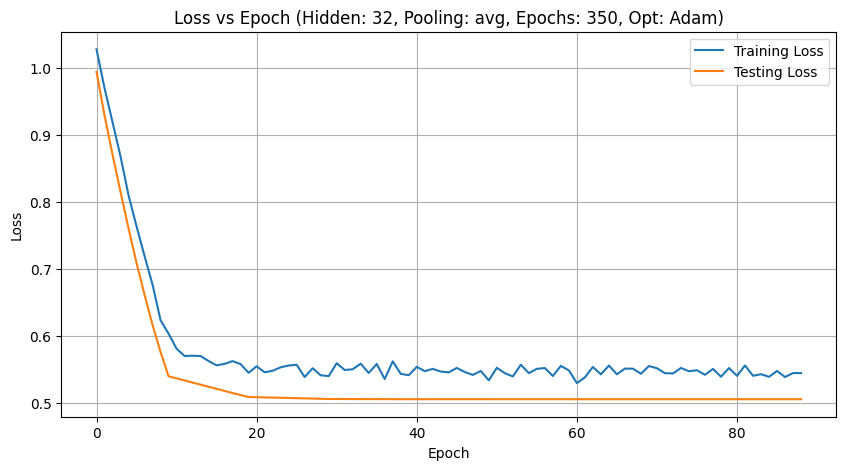

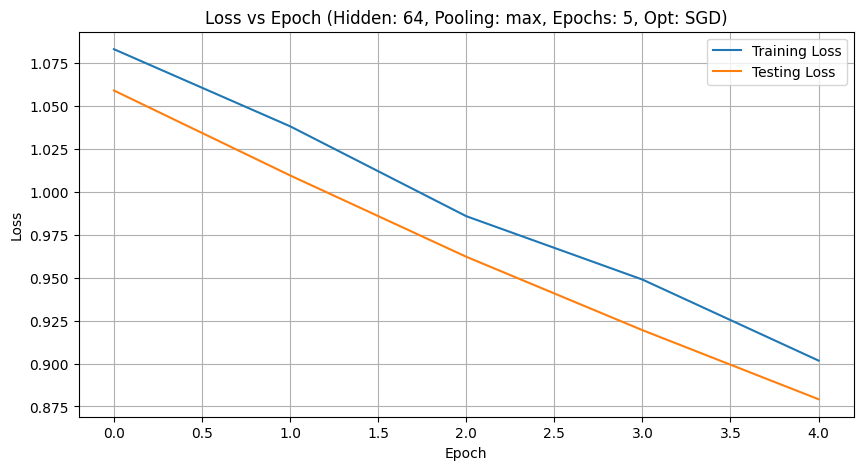

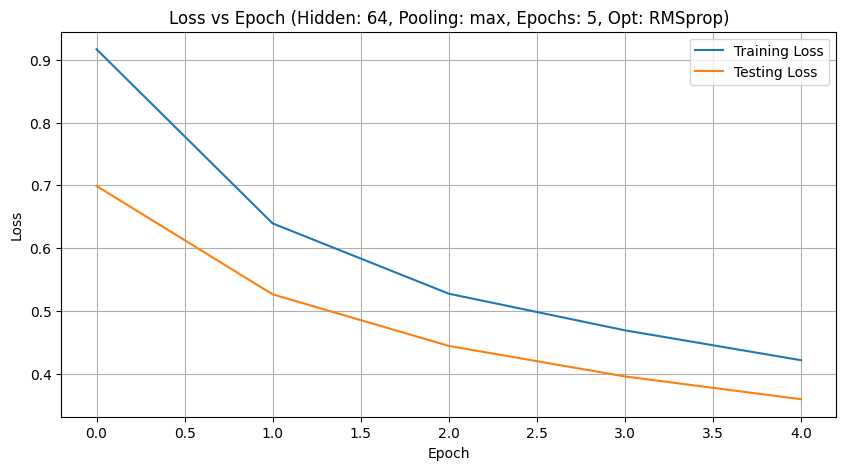

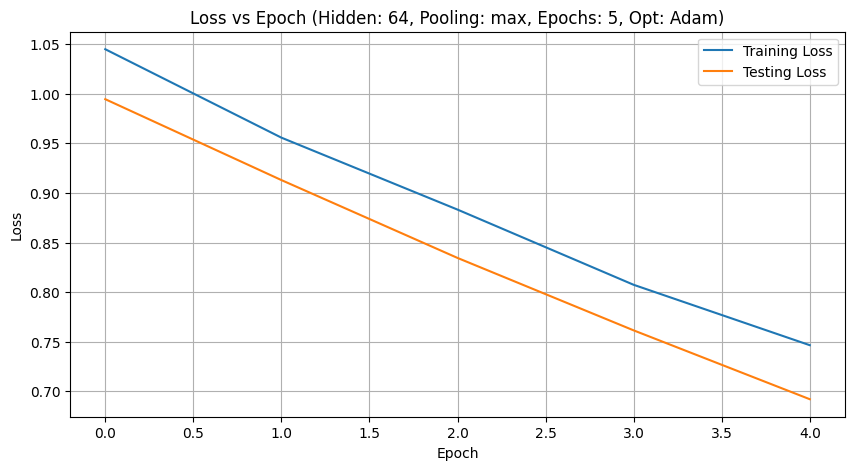

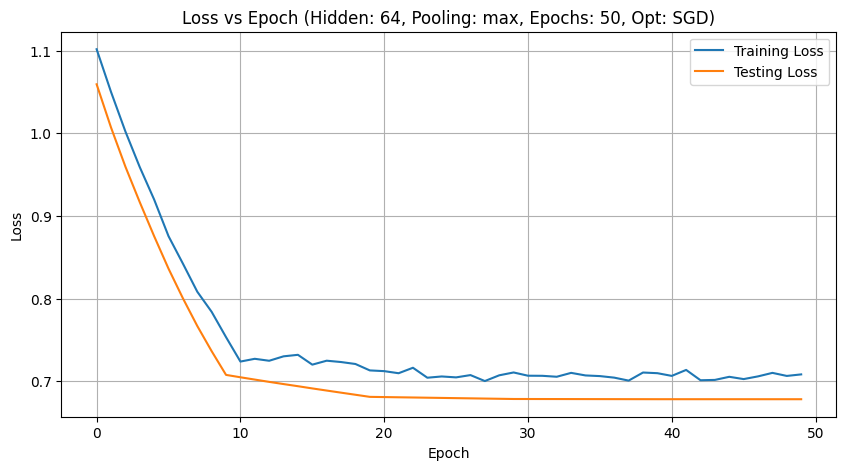

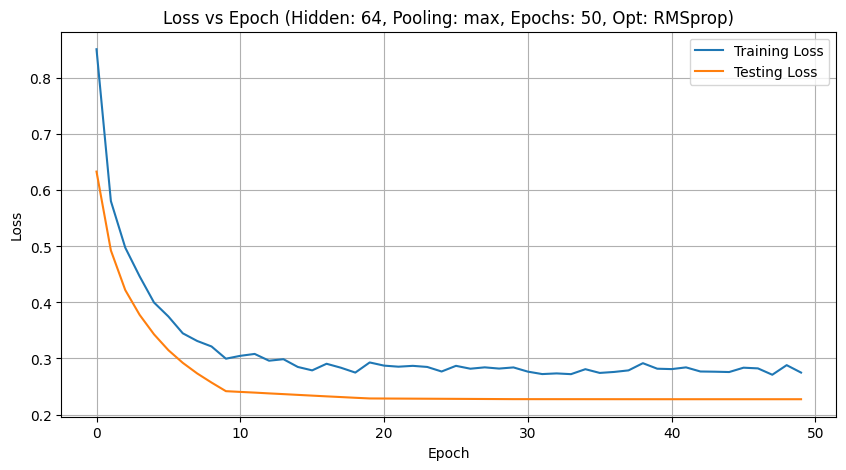

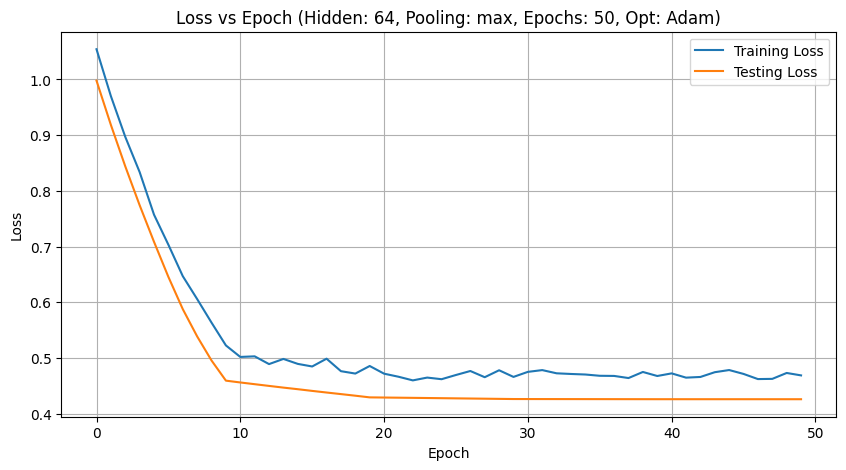

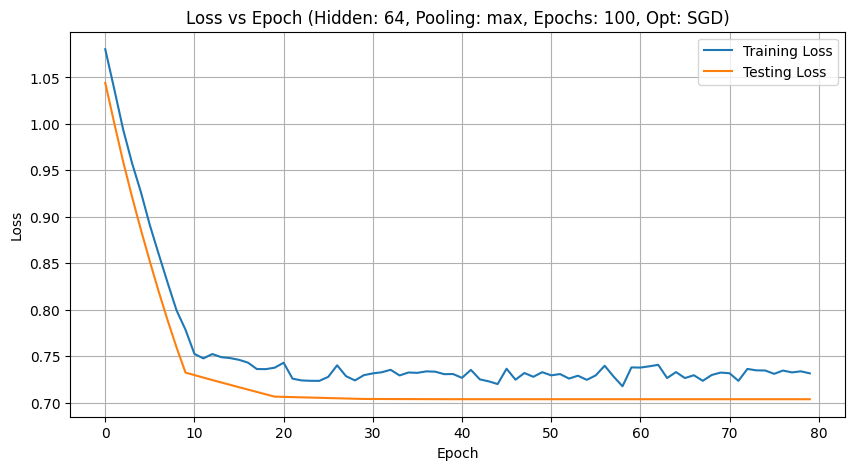

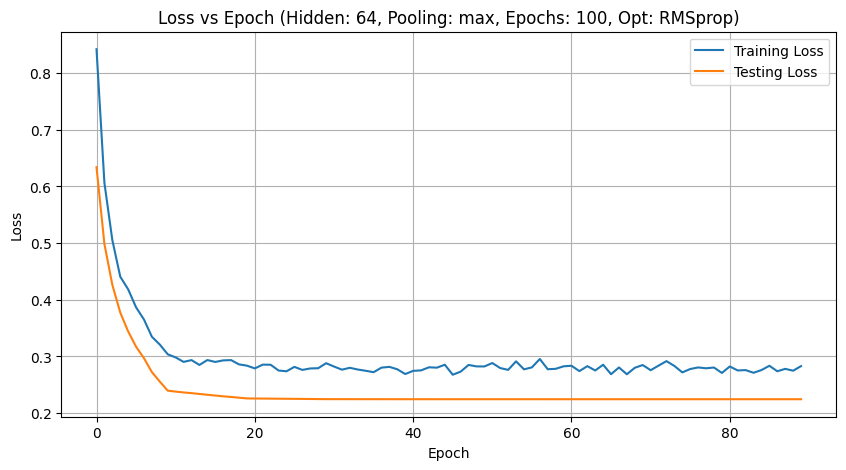

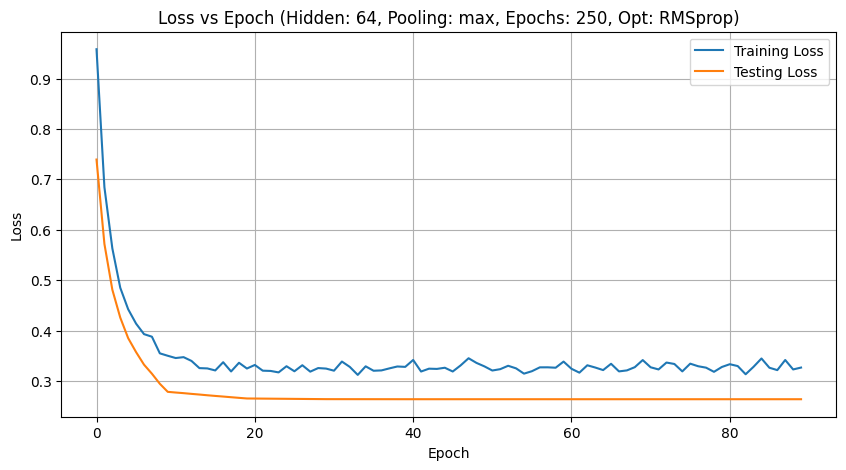

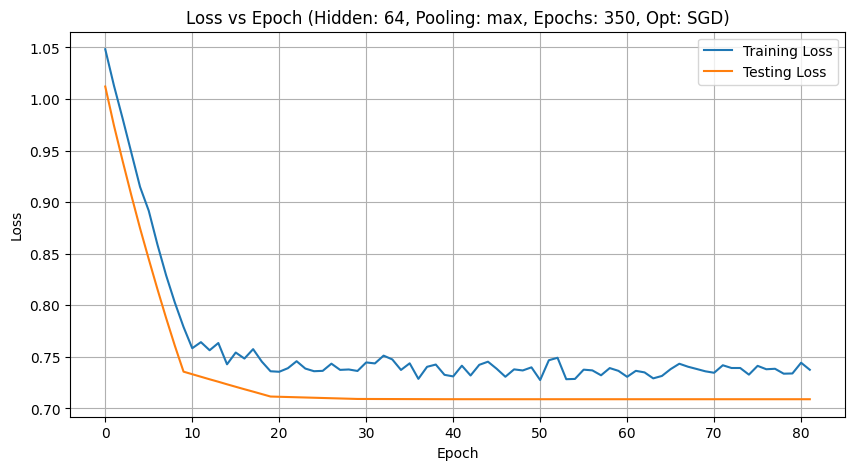

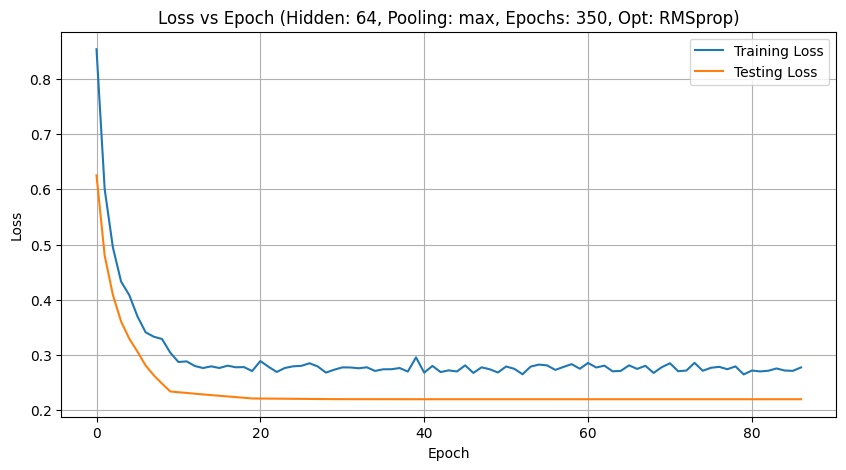

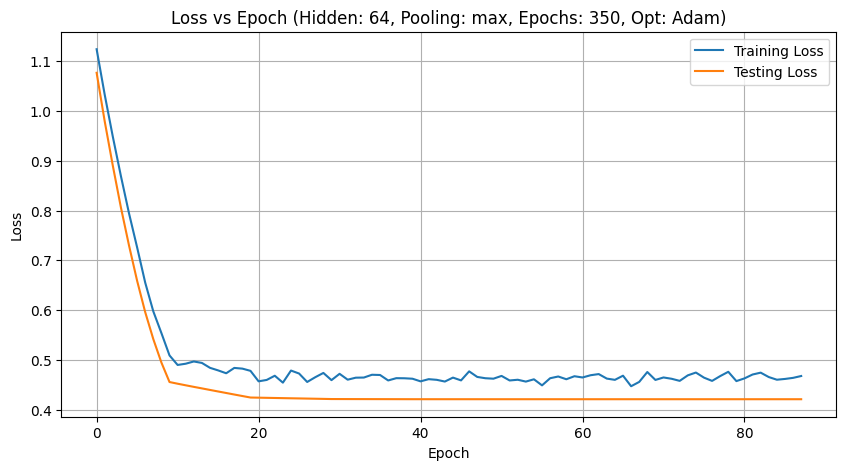

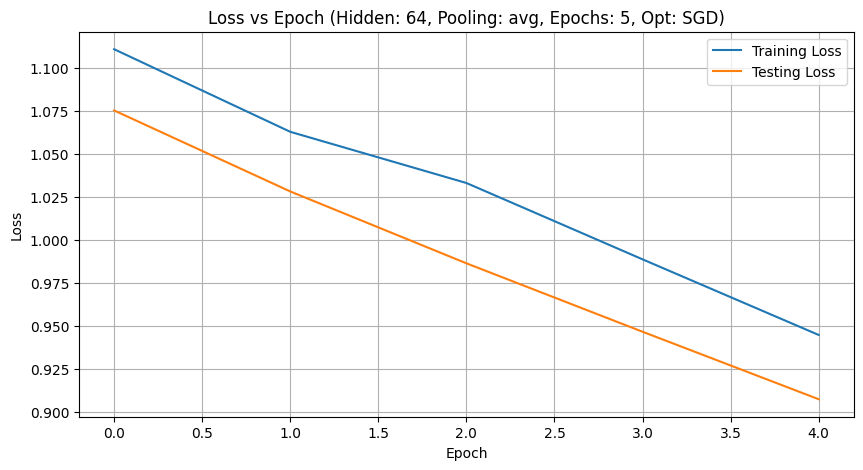

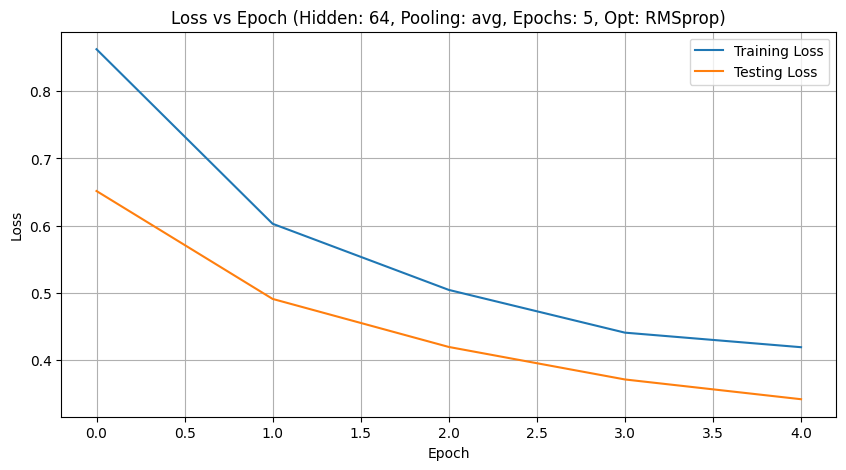

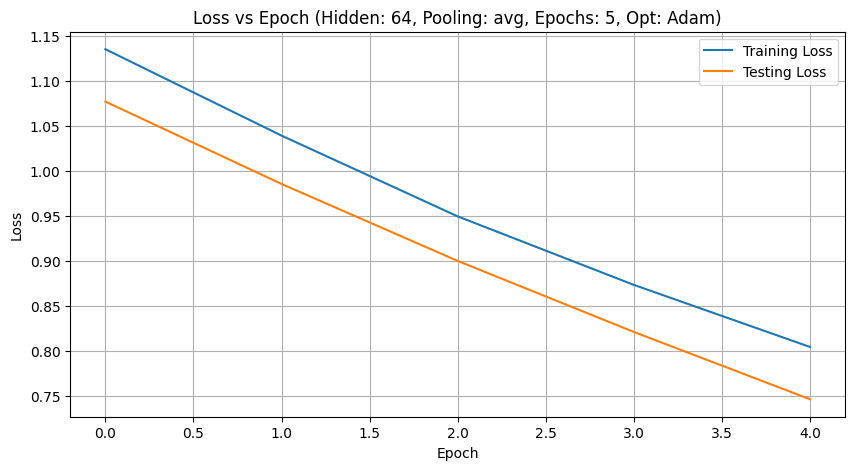

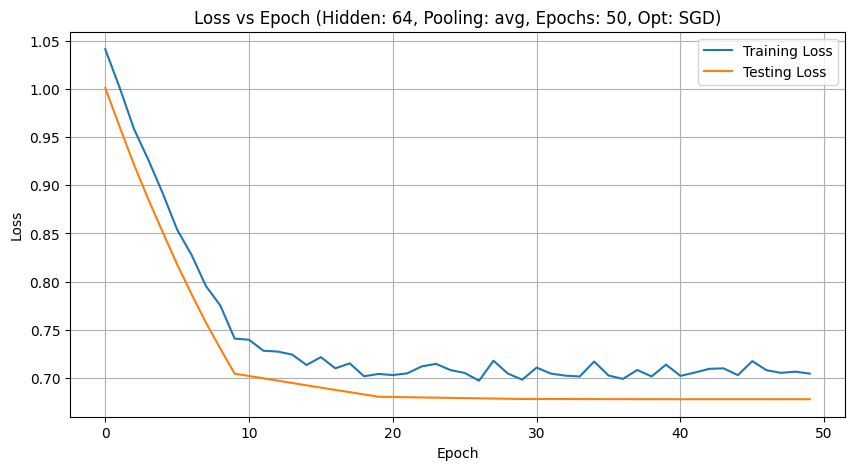

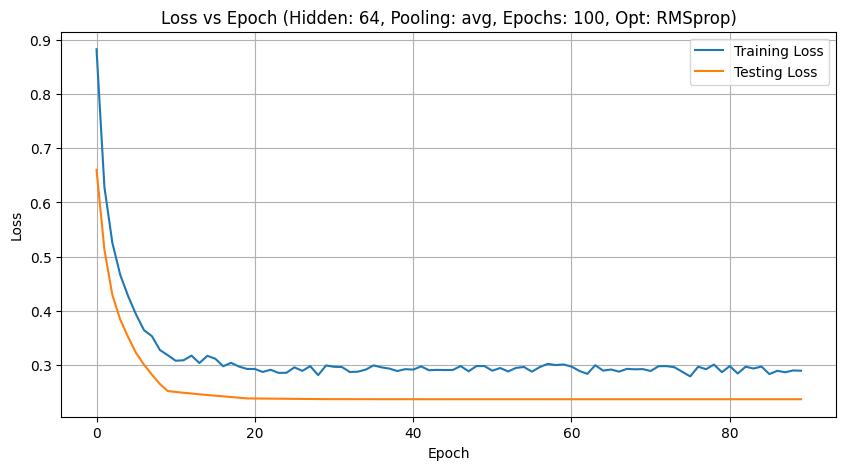

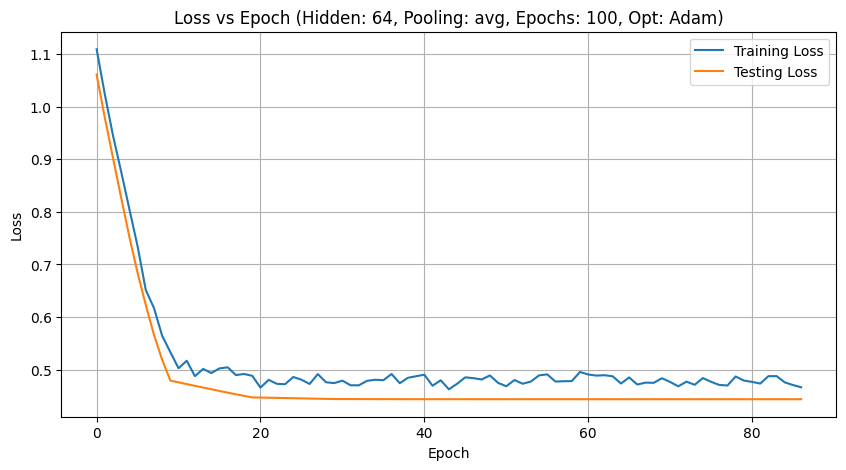

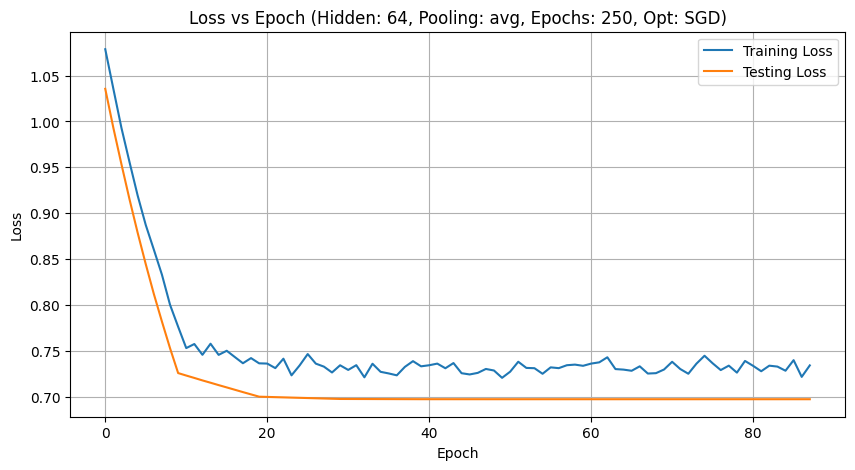

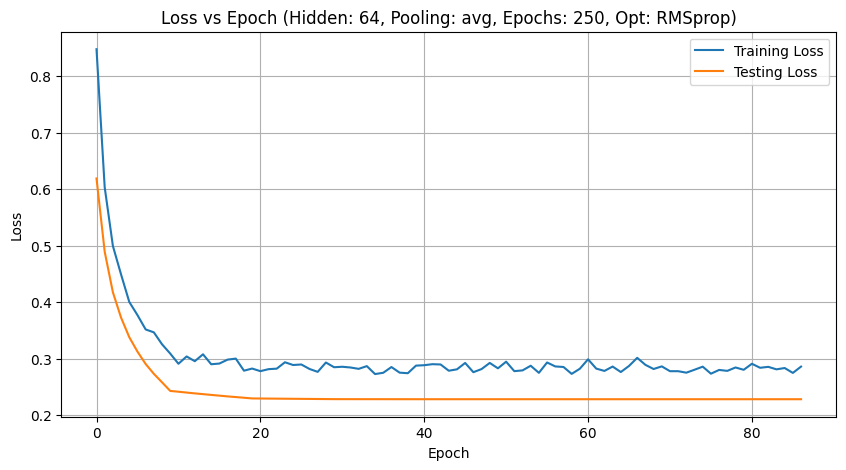

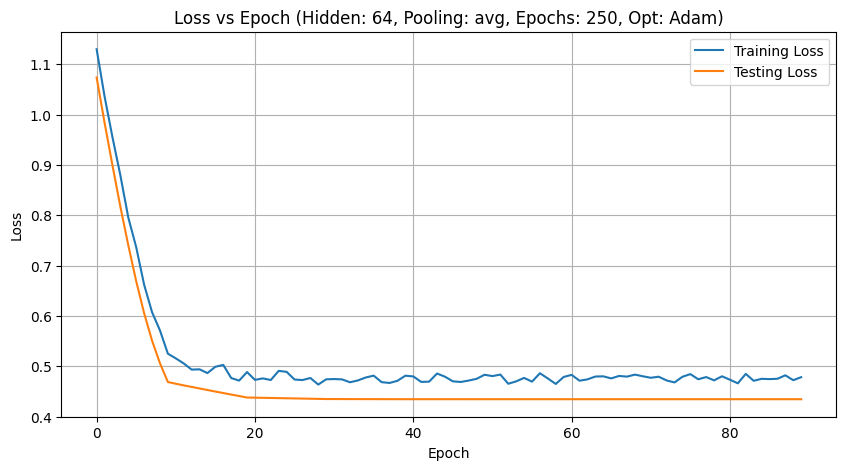

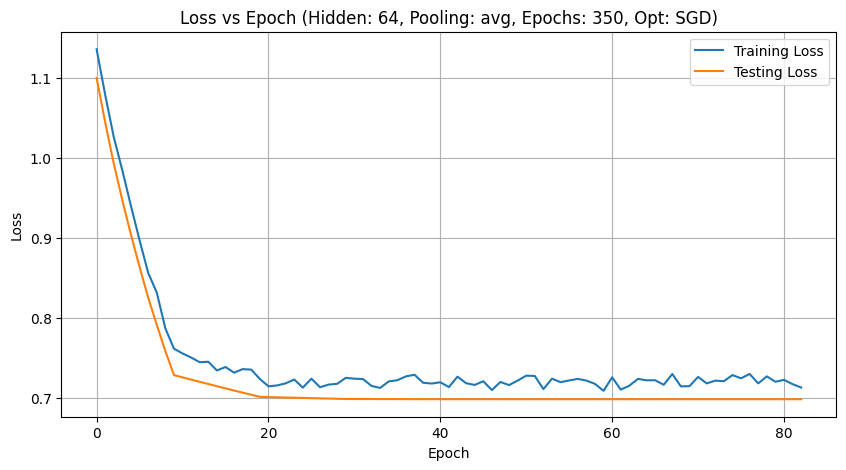

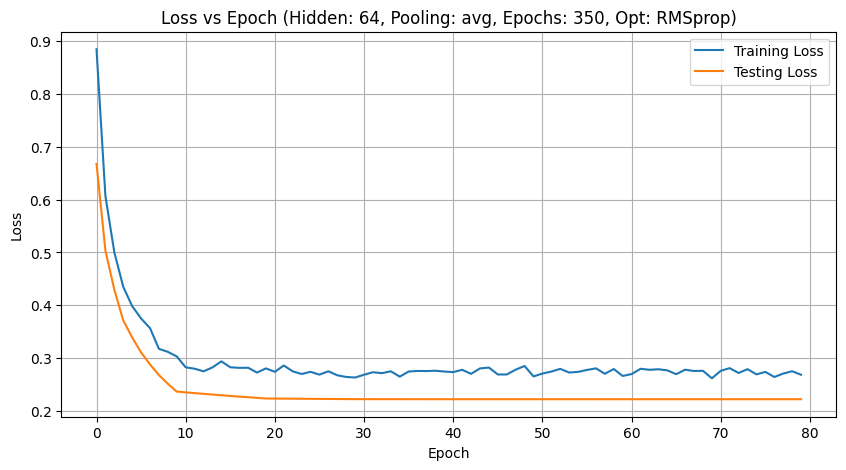

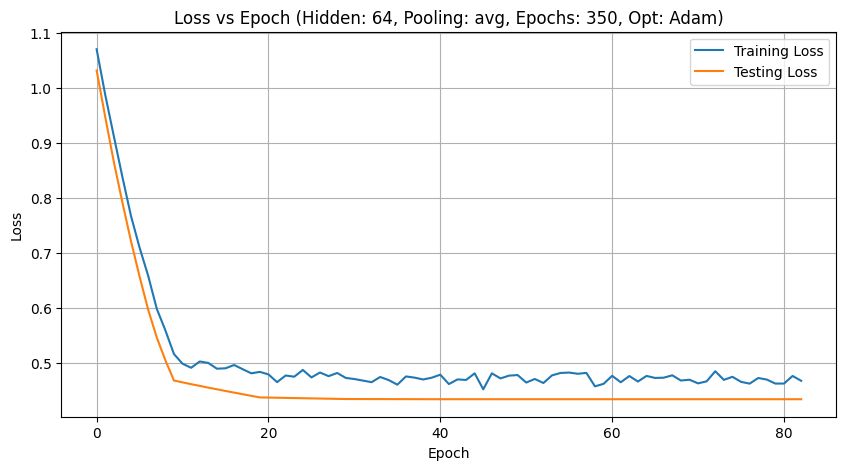

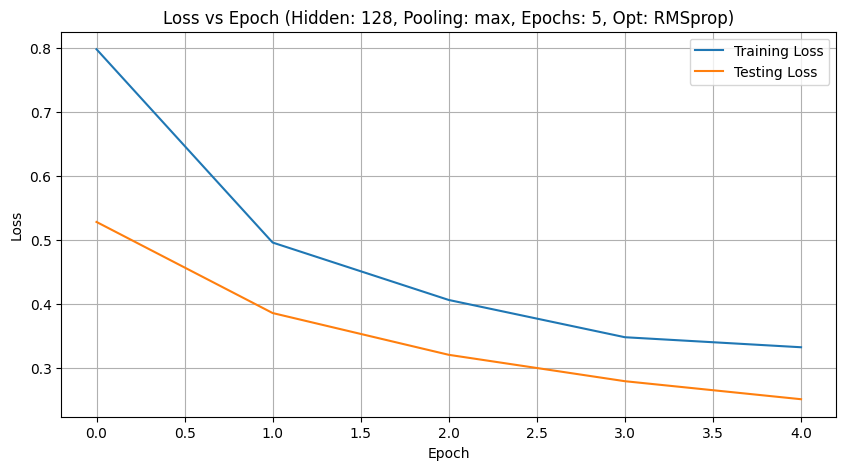

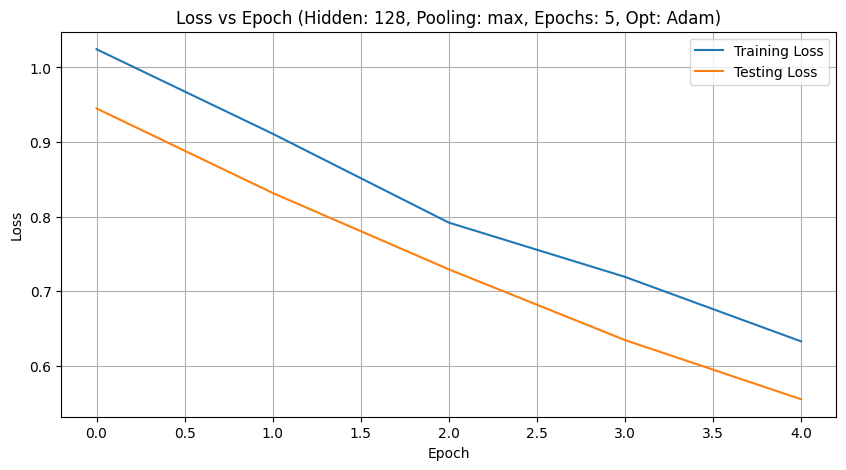

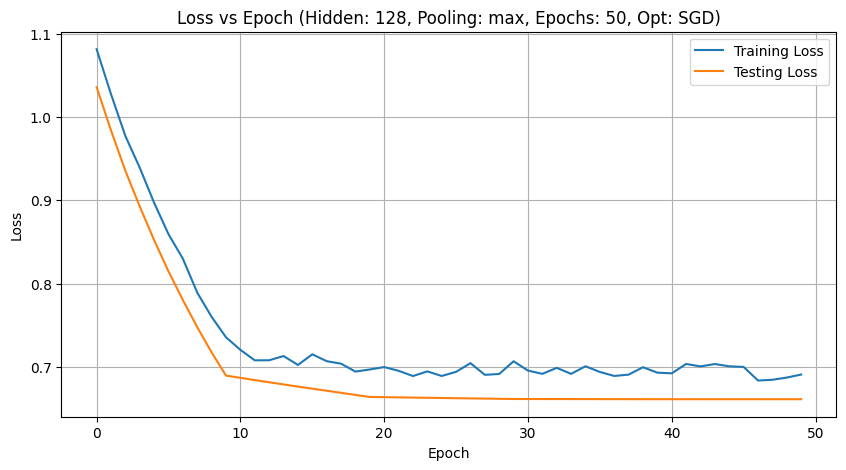

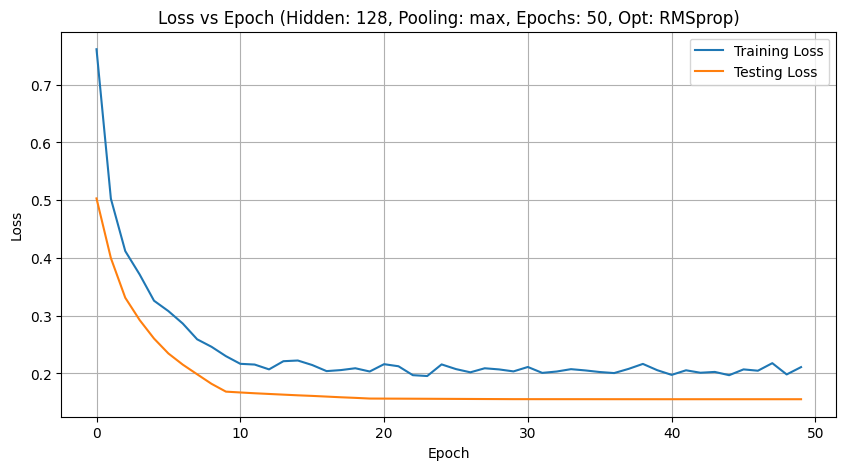

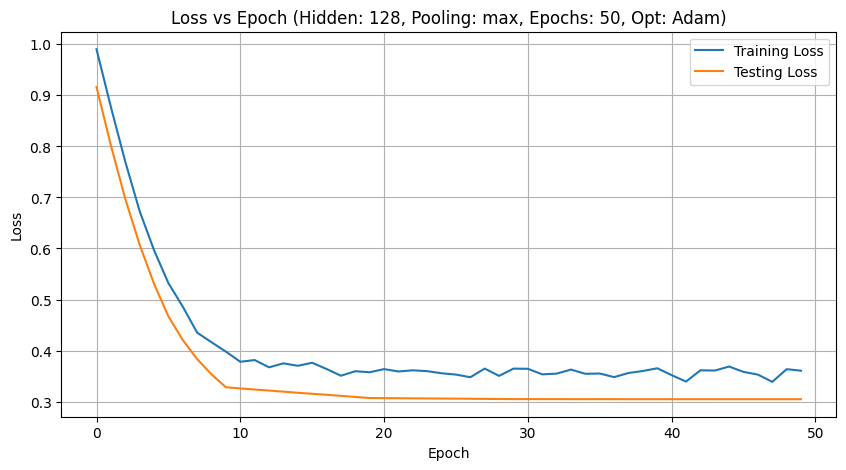

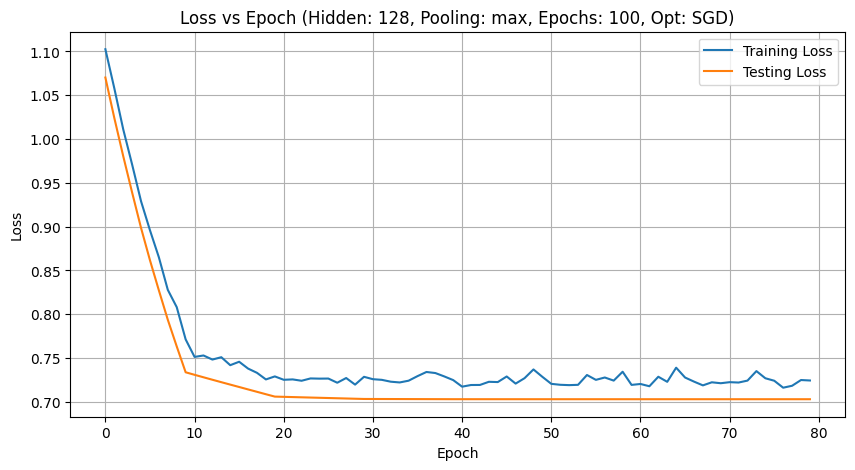

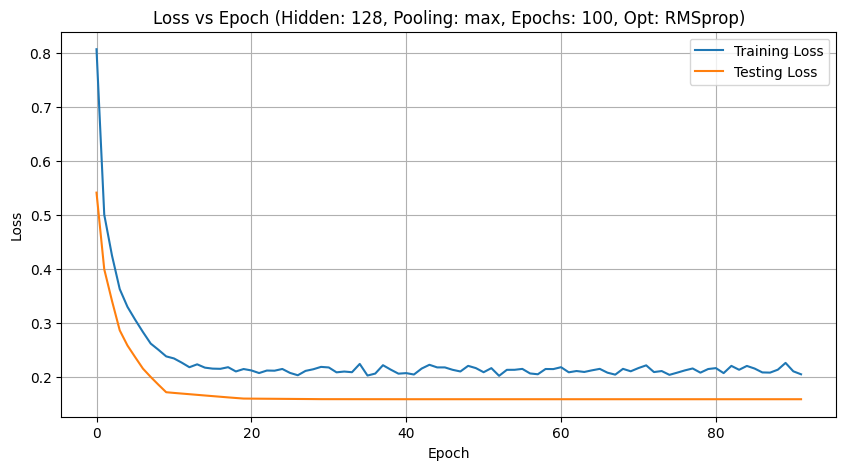

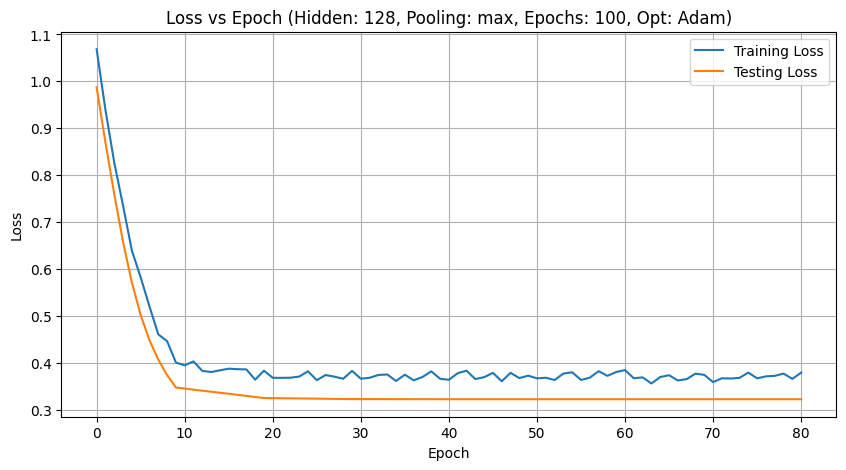

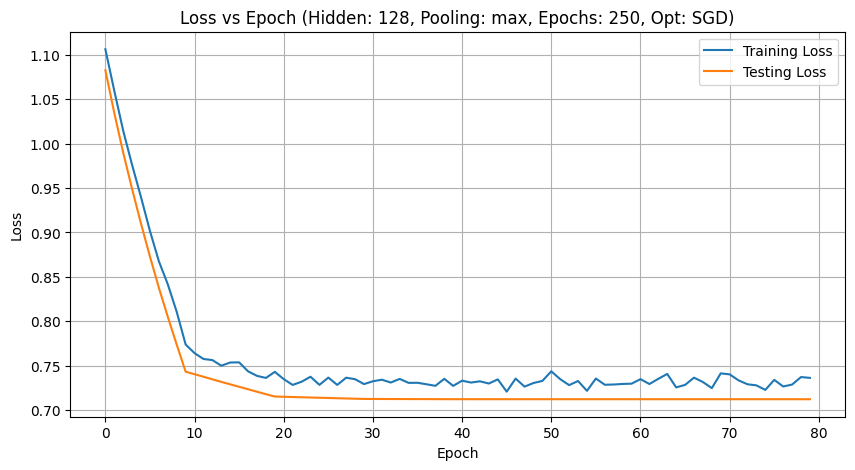

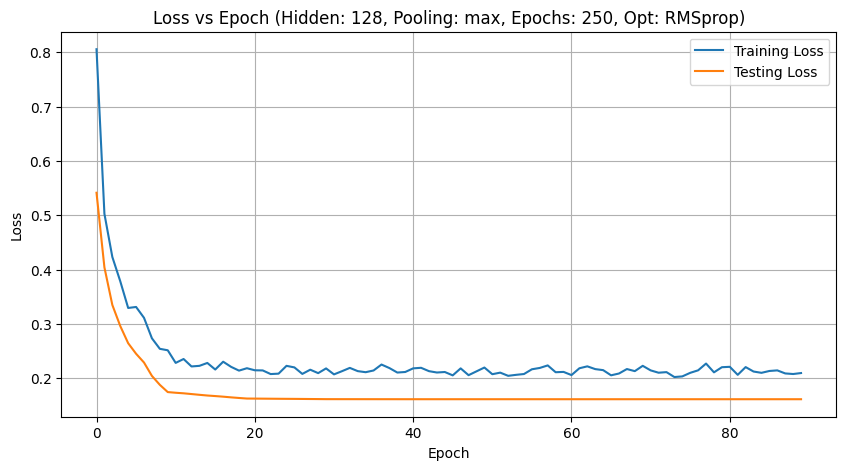

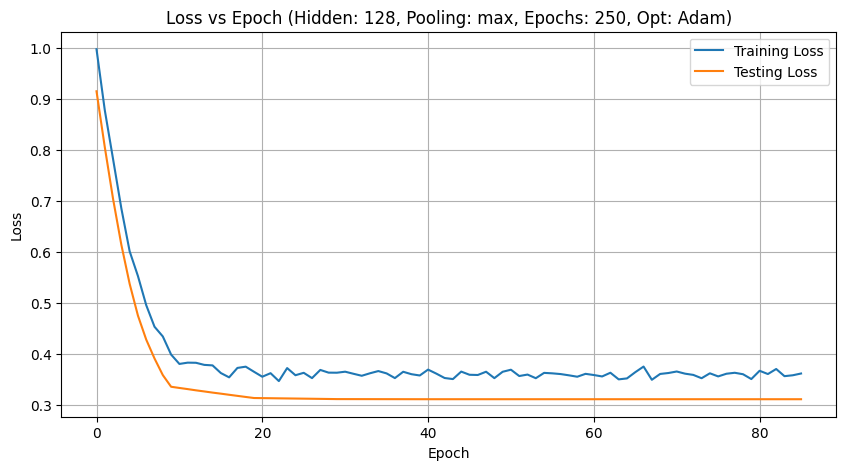

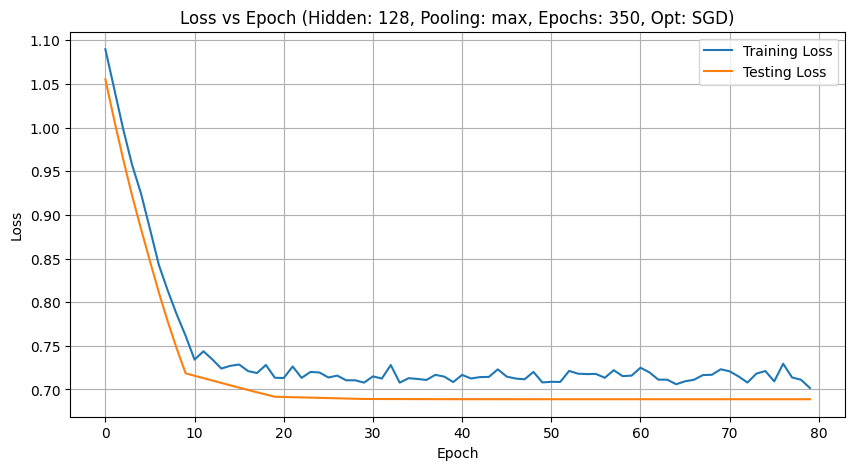

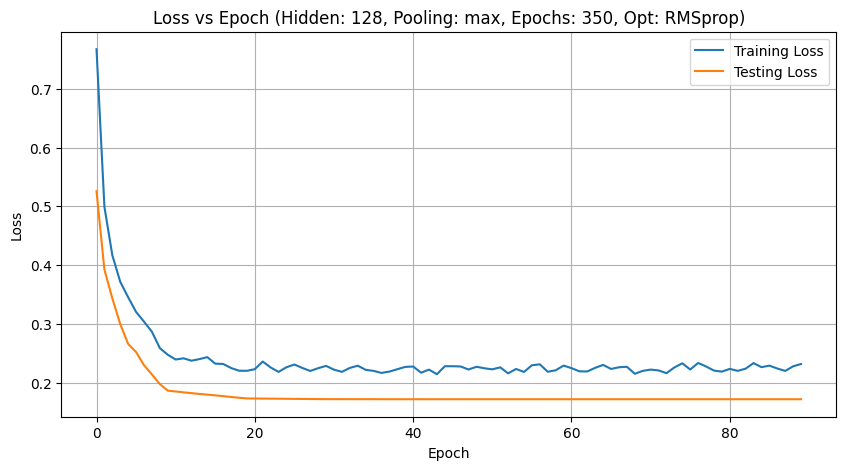

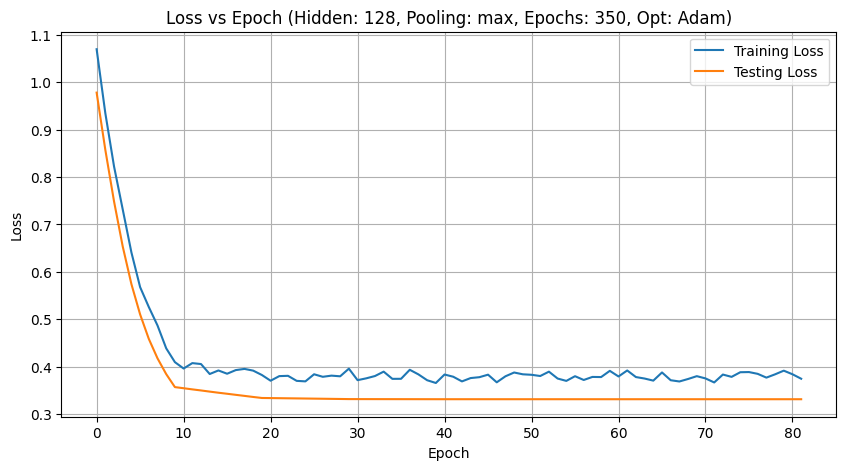

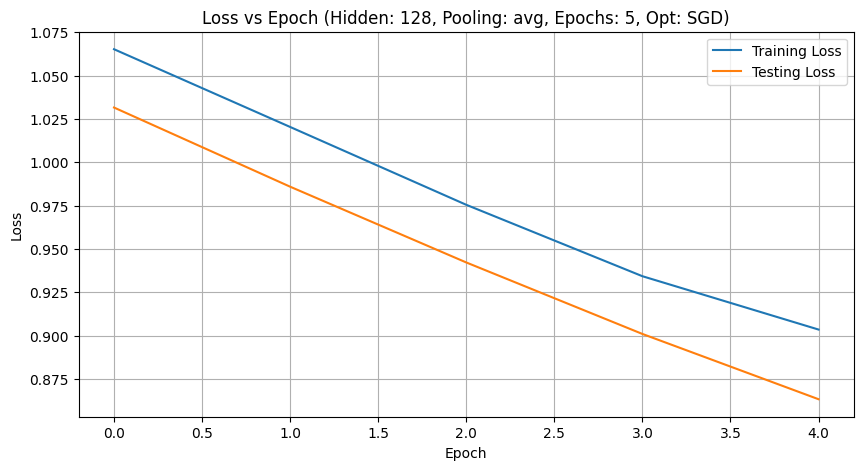

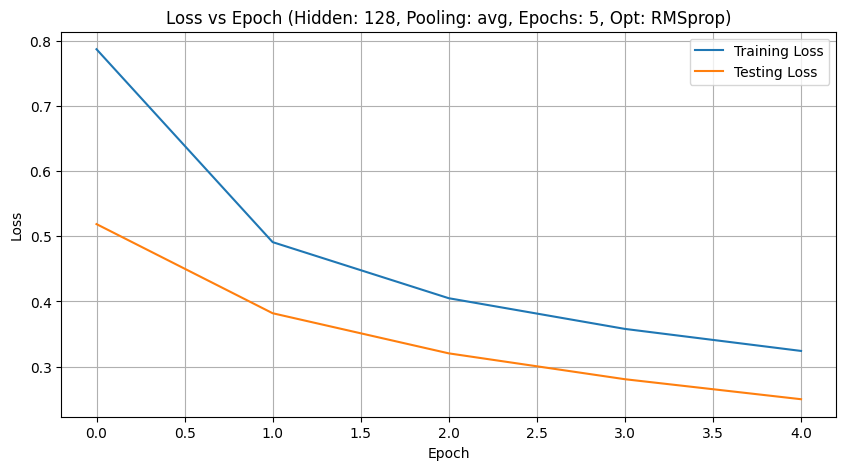

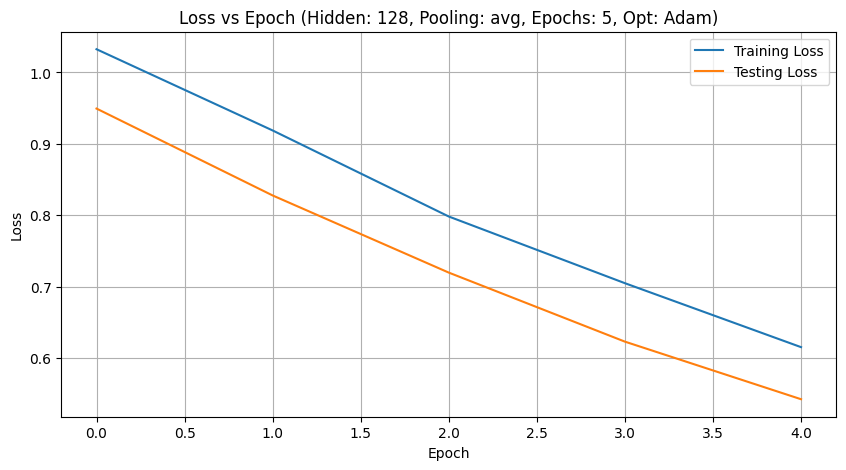

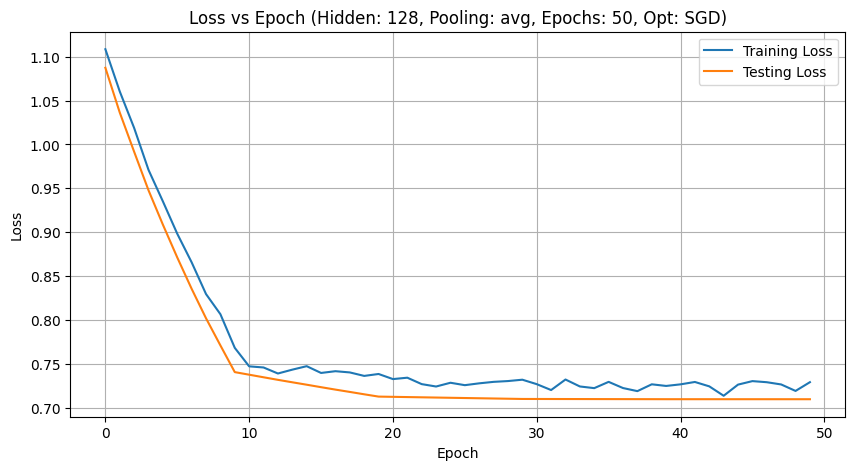

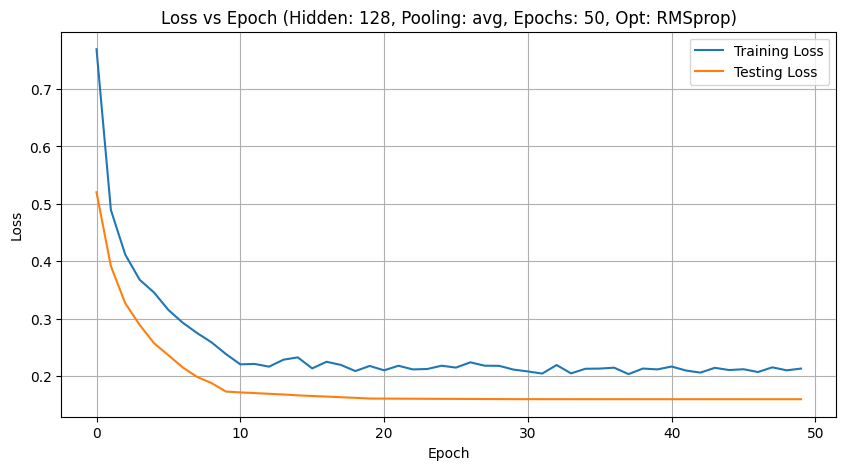

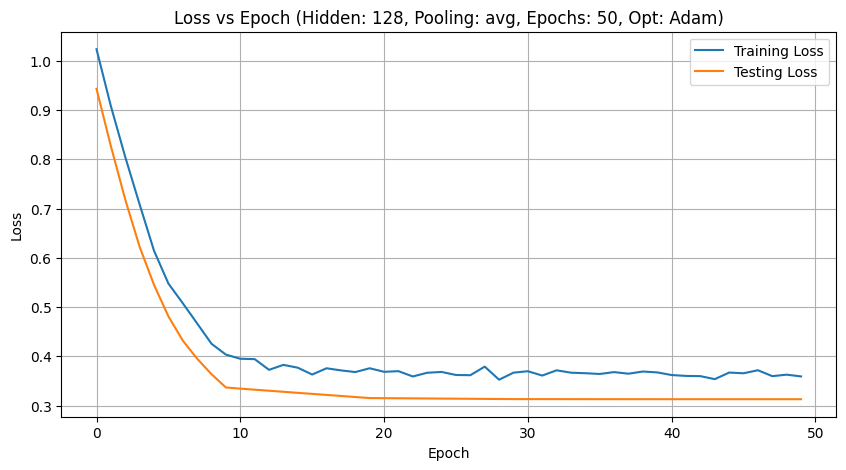

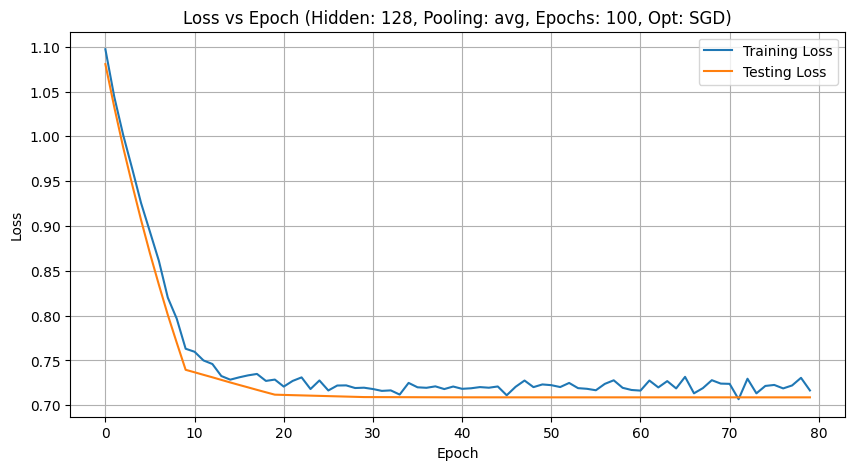

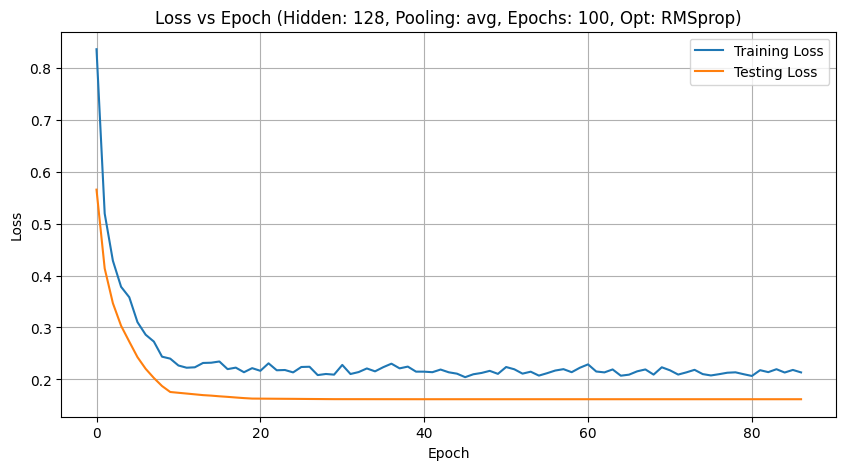

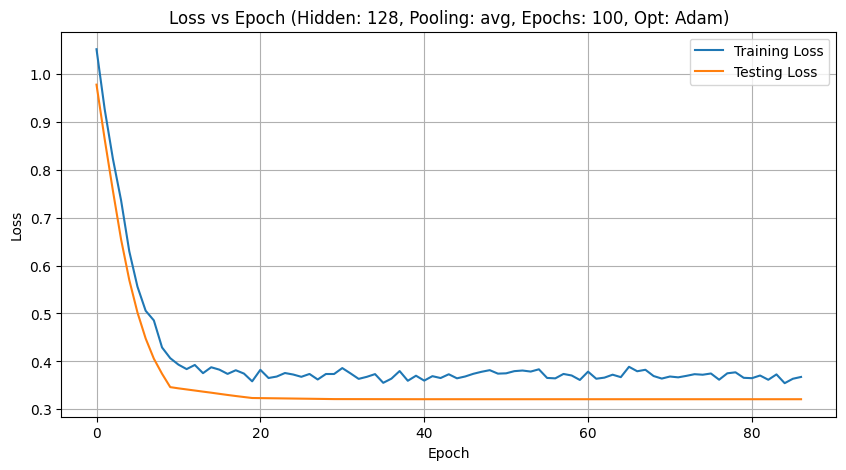

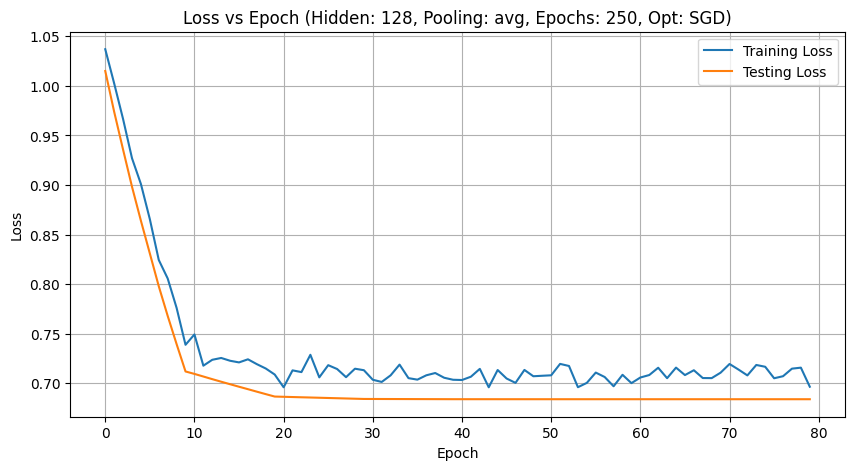

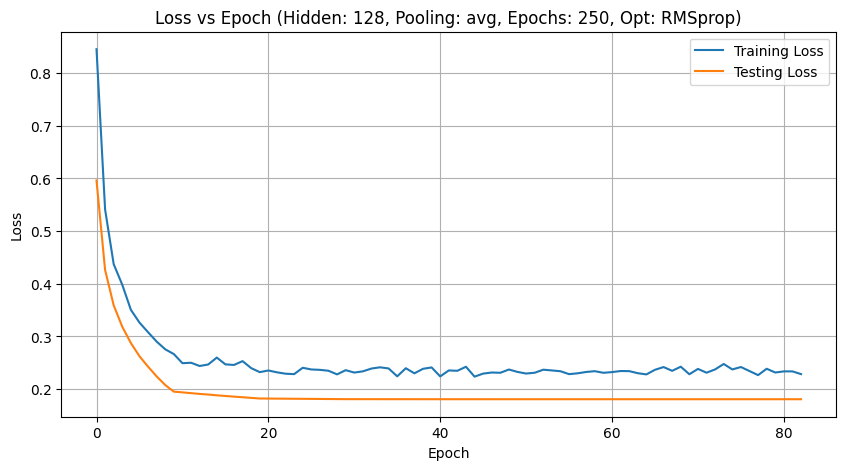

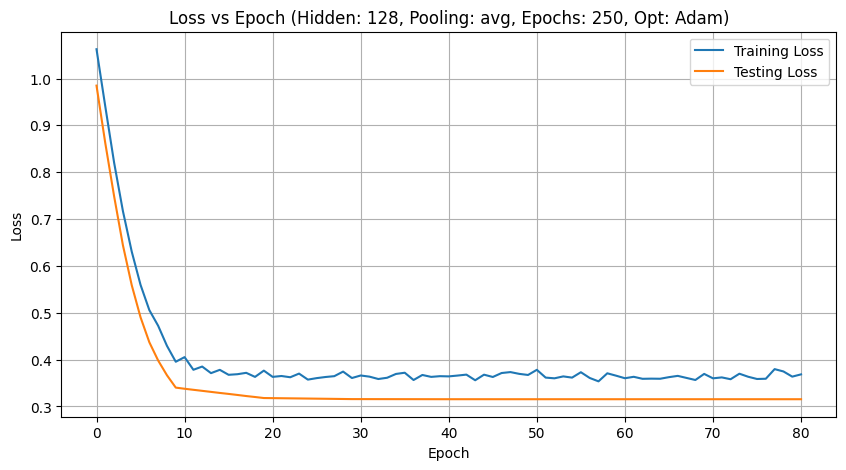

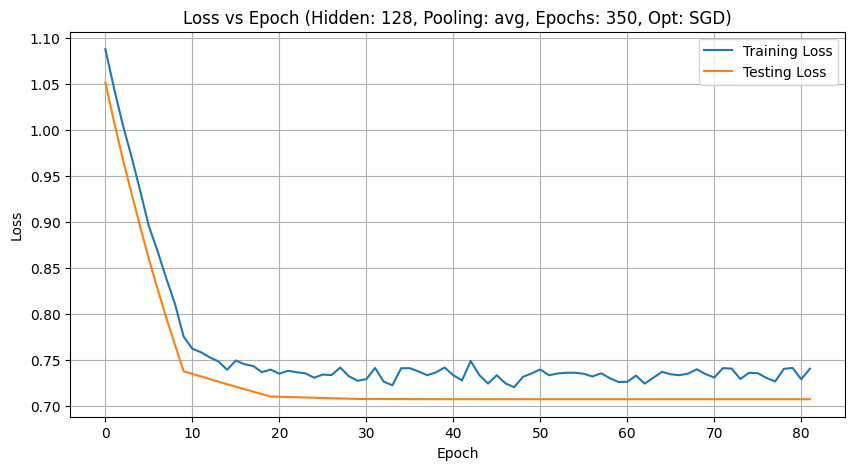

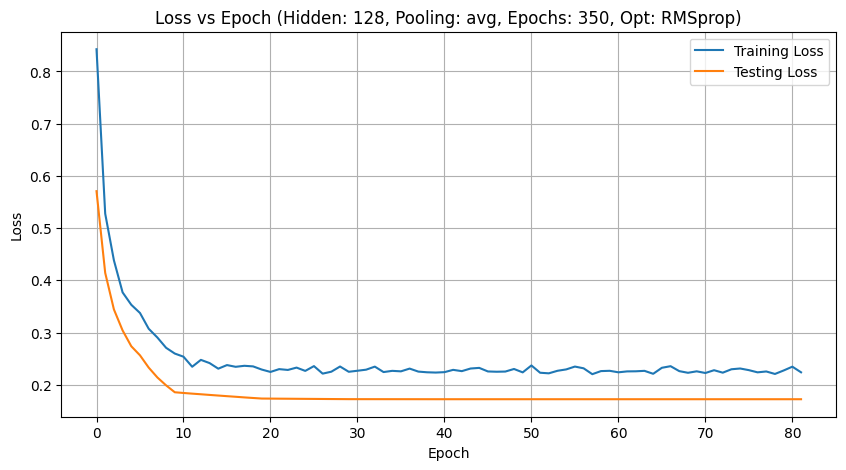

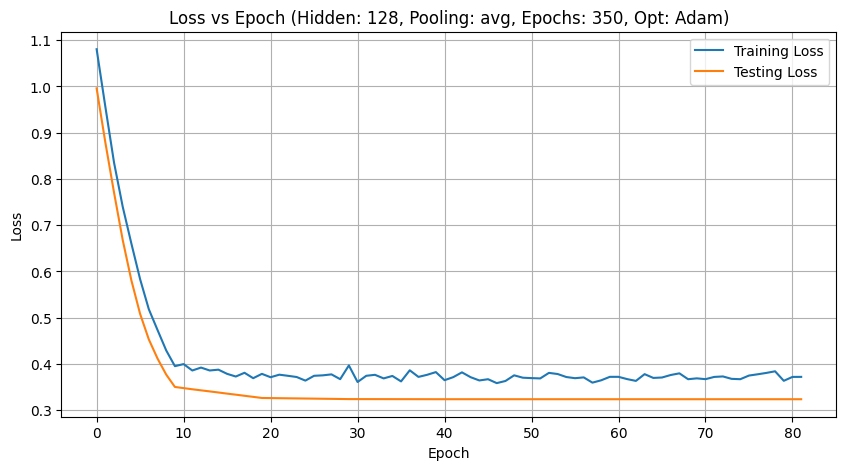

In [70]:
import matplotlib.pyplot as plt

#7. Analisis Hasil
for (hidden_size, pooling_type, epochs, optimizer_name), losses in results.items():
    train_losses = losses['train_losses']
    test_losses = losses['test_losses']

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss vs Epoch (Hidden: {hidden_size}, Pooling: {pooling_type}, Epochs: {epochs}, Opt: {optimizer_name})')
    plt.legend()
    plt.grid(True)
    plt.show()